In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np
from scipy.spatial import ConvexHull

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Atoms
from ase.io import read

# ML
from kernels import sqeuclidean_distances

# Utilities
import h5py
import json
import project_utils as utils
import gzip
from copy import deepcopy

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

In [2]:
# TODO: analysis for all GCH's (different PCovR mixing)

In [3]:
cantons_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
iza_delete = np.nonzero(cantons_iza == 4)[0][0]
deem_delete = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [4]:
iza_codes = np.loadtxt(f'../../Raw_Data/GULP/IZA_226/codes.txt', dtype=str)
iza_codes = np.delete(iza_codes, iza_delete)
cantons_iza = np.delete(cantons_iza, iza_delete)

In [5]:
# Structure energies
deem_330k_energies = np.loadtxt('../../Raw_Data/GULP/DEEM_330k/optimization_summary_fix.dat', usecols=2)
deem_330k_energies = np.delete(deem_330k_energies, deem_delete)

# TODO: change this when IZA re-optimized
iza_energies = np.loadtxt('../../Processed_Data/IZA_226/Data/structure_energies.dat')
iza_energies = np.delete(iza_energies, iza_delete)
n_iza = len(iza_energies)

energies = np.concatenate((iza_energies, deem_330k_energies))

In [6]:
# Structure volumes
deem_330k_volumes = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_volumes.dat')
deem_330k_volumes = np.delete(deem_330k_energies, deem_delete)

iza_volumes = np.loadtxt('../../Processed_Data/IZA_226/Data/structure_volumes.dat')
iza_volumes = np.delete(iza_energies, iza_delete)
n_iza = len(iza_energies)

volumes = np.concatenate((iza_volumes, deem_330k_volumes))

In [7]:
# Hull distances (TODO: change this so we just save all the useful properties from the GCH notebook)
gch_dir = '../../Processed_Data/Models/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/GCH'
vprobprune = np.loadtxt(f'{gch_dir}/rattled/vprobprune.dat')
T = np.loadtxt(f'{gch_dir}/T.dat')
ndim = 3

gch_vertices = np.nonzero(vprobprune[-1])[0]

e_gch = energies[gch_vertices]
T_gch = T[gch_vertices, :]

eT = np.hstack((e_gch[:, np.newaxis], T_gch))
eT_all = np.hstack((energies[:, np.newaxis], T))
vertex_hull = ConvexHull(eT[:, 0:ndim])

# Omit simplices on the "top" of the GCH
vertex_hull_facets = np.delete(vertex_hull.equations, 
                               np.nonzero(vertex_hull.equations[:, 0] > 0.0),
                               axis=0)

d = -(np.matmul(eT_all[:, 0:ndim], vertex_hull_facets[:, 0:-1].T) + vertex_hull_facets[:, -1])
de = -d / vertex_hull_facets[:, 0]
d = np.amin(np.abs(d), axis=1)
de = np.amin(np.abs(de), axis=1)

In [8]:
vertices = np.zeros(T.shape[0], dtype=int)
vertices[gch_vertices] = 1

## Check that vertices built on the hull of the GCH vertices are in fact the GCH vertices

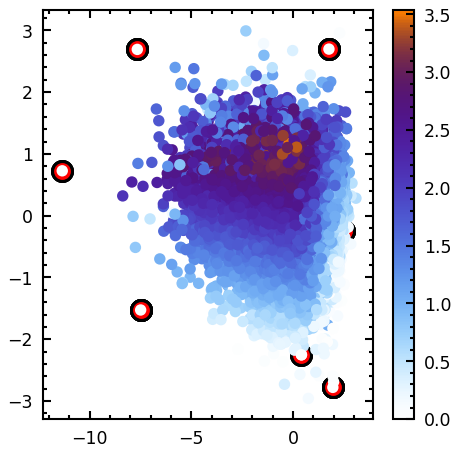

In [9]:
for vertex_simplex in vertex_hull.simplices:
    plt.scatter(T_gch[vertex_simplex, 0], T_gch[vertex_simplex, 1], c='k', s=100)
    
plt.scatter(T_gch[vertex_hull.vertices, 0], T_gch[vertex_hull.vertices, 1], c='r', s=50)
plt.scatter(T[:, 0], T[:, 1], c=d, s=20)
plt.colorbar()
plt.show()

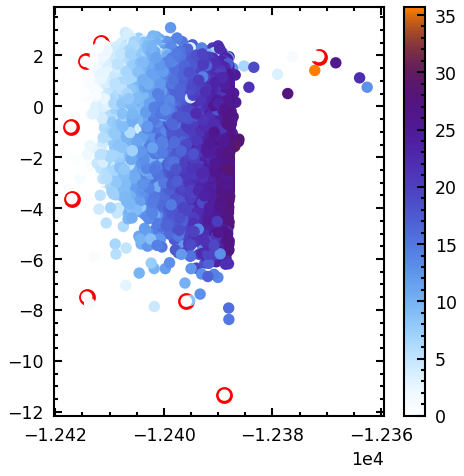

In [10]:
plt.scatter(eT_all[gch_vertices, 0], eT_all[gch_vertices, 1], c='r', s=50)
plt.scatter(eT_all[:,0], eT_all[:,1], c=de, s=20)
plt.colorbar()
plt.show()

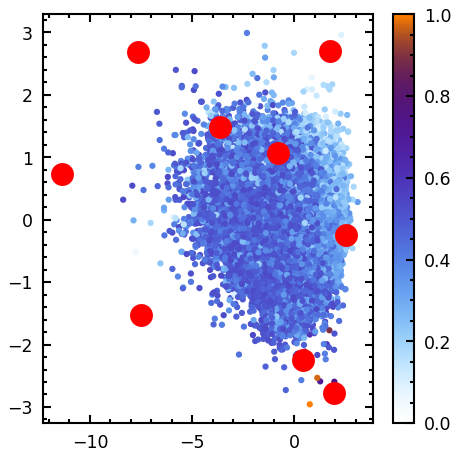

In [11]:
plt.scatter(T[:, 0], T[:, 1], c=energies)
plt.scatter(T[gch_vertices, 0], T[gch_vertices, 1], c='r', s=100)
plt.colorbar()
plt.show()

# Structure analysis

# Hull stats

In [35]:
print(np.argmax(de), np.amax(de))

192 35.70567793805634


In [36]:
iza_de = np.argsort(de)
iza_de = iza_de[iza_de < n_iza]
for d, code, canton in zip(de[iza_de], iza_codes[iza_de], cantons_iza[iza_de]):
    print(f'{code[-3:]}\t{canton}\t{d}')

OBW	2	0.0
ANA	2	0.0
BOZ	3	0.2645608113568298
AFO	3	0.43436148296641874
RSN	2	0.5491144432480695
CHA	2	0.7224645097324086
GIS	2	0.758560264982991
ASV	3	1.0083578786543514
NPT	3	1.3285041305864127
THO	2	1.332628111458193
OWE	3	2.0241438017355895
AFI	3	2.0778054451864074
LTJ	2	2.2101390724691528
AFV	3	2.232462697664166
VET	1	2.748290268240208
LOV	2	3.122577271514984
BSV	3	3.3892088841772496
ATV	3	3.4185937717884323
SIV	3	3.608169107133739
AEI	3	3.6524176006797497
EDI	2	3.822395815044506
GON	1	3.8981138515929357
DFT	3	3.987227202621811
TON	2	4.356714175998029
DON	1	4.418060856274612
MWF	2	4.453924953850863
MTT	2	4.491049308436649
AFT	3	4.506624948272711
MTF	1	4.5561020725156
PSI	3	4.609821619598742
AEL	3	4.6242571186123085
SAF	3	4.664268470384574
AWO	3	4.770063277666449
SBN	3	4.781480956229812
AVL	3	4.97325570982617
MTW	2	4.974933493379175
MFI	2	5.033180601075783
CAS	2	5.048882837342164
JBW	2	5.142521572973293
JRY	3	5.31589326137932
NSI	1	5.535565135961564
AEN	3	5.559866822012769
PCR	1	5.5

In [37]:
canton_1_idxs = np.nonzero(cantons_iza == 1)[0]
iza_de = np.argsort(de[canton_1_idxs])
for d, code, canton in zip(de[canton_1_idxs][iza_de], iza_codes[canton_1_idxs][iza_de], cantons_iza[canton_1_idxs][iza_de]):
    print(f'{code[-3:]}\t{canton}\t{d}')

VET	1	2.748290268240208
GON	1	3.8981138515929357
DON	1	4.418060856274612
MTF	1	4.5561020725156
NSI	1	5.535565135961564
PCR	1	5.563913886931763
IHW	1	6.416189080496206
IMF	1	6.551837738982654
SFE	1	6.5916474389318225
DOH	1	6.937065843418276
ITH	1	6.950362678675777
RTE	1	7.065005936321385
ETL	1	7.147279813136401
MEP	1	7.273447402019032
EEI	1	7.374234605668328
NON	1	7.485934867931927
DDR	1	7.9171340287597936
CFI	1	8.231793497590129
SGT	1	8.316341524145455
ITE	1	8.660450986149565
STF	1	9.189658569898995
SFF	1	9.401530125449746
UOV	1	9.417544174503947
IFR	1	9.478194235527614
ITW	1	9.568242716537203
RRO	1	9.663561551126264
MTN	1	9.698224718667996
STT	1	9.753860229318004
OKO	1	9.800618789159625
ISV	1	10.740115901520717
CDO	1	11.00790132150343
RWR	1	11.200731600865426
CSV	1	11.366945769469634
LTF	1	11.66685959774316
IFY	1	14.25921228450328


In [38]:
de_limit = de[canton_1_idxs][iza_de][-1]
print(de_limit)

14.25921228450328


## SVM-based candidates

In [39]:
def k_nearest_neighbors(A, B, y, k=1):
    """
        Computes the property y' for dataset A
        based on the average of properties y of 
        the k closest instances of dataset B 
        (Euclidean distance)
        
        ---Arguments---
        A: dataset with unknown properties
        B: "reference" dataset with known properties
        y: known properties of dataset B
        k: number of nearest neighbors
        
        ---Returns---
        yy: k-nearest-neighbor properties for dataset A
    """
    # TODO: generalize to accept also 1D arrays
    # TODO: move to general utilities
    D = np.sqrt(sqeuclidean_distances(A, B))
    idxs = np.argsort(D, axis=1)[:, 0:k]
    yy = np.mean(y[idxs], axis=1)
    return yy

In [67]:
# Most IZA-like Deem structures (lowest decision function value)
dfs_2 = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
#dfs_2 = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat', usecols=3)

In [41]:
Si_fraction_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/ChemComp_F.txt', usecols=1)
Si_fraction_iza = np.delete(Si_fraction_iza, iza_delete)
Si_fraction_deem = np.ones(len(dfs_2)) / 3
Si_fraction = np.concatenate((Si_fraction_iza, Si_fraction_deem))

In [42]:
deem_codes = np.arange(0, 331172) + 8000001
deem_codes = np.delete(deem_codes, deem_delete)

In [43]:
most_iza = np.argsort(dfs_2)
most_iza = np.delete(most_iza, deem_delete)
idxs_sort = np.argsort(most_iza[0:5])
idxs_rev = np.argsort(idxs_sort)

print(most_iza[0:5] + 8000001)
print(dfs_2[most_iza[0:5]])
print(Si_fraction_deem[most_iza[0:5]])


# Load SOAPs
deem_soaps_file = h5py.File('../../Processed_Data/DEEM_330k/Data/6.0/soaps_power_full_avg_nonorm.hdf5', 'r')
deem_soaps = deem_soaps_file['0'][most_iza[0:5][idxs_sort], :]
deem_soaps_file.close()
deem_soaps = deem_soaps[idxs_rev]

iza_soaps = utils.load_hdf5('../../Processed_Data/IZA_226/Data/6.0/soaps_power_full_avg_nonorm.hdf5', datasets=None, concatenate=True)
iza_soaps = np.delete(iza_soaps, iza_delete, axis=0)

predicted_Si_fraction = k_nearest_neighbors(deem_soaps, iza_soaps, Si_fraction_iza, k=1)
print(predicted_Si_fraction.squeeze())

[8283748 8162065 8204697 8162069 8308516]
[-4.98832126 -4.58181763 -4.57680163 -4.02409464 -3.87917261]
[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
[0.33333 0.33333 0.33333 0.33333 0.33333]


In [69]:
dfs_2[301973]

-0.09039436967202667

In [44]:
# Most Deem-like Deem
print(most_iza[-5:] + 8000001)
print(dfs_2[most_iza[-5:]])
print(Si_fraction_deem[most_iza[-5:]])

[8229490 8286863 8154295 8054203 8129504]
[14.19838471 14.63990237 14.68153013 14.80411226 18.56985358]
[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]


In [45]:
# Most IZA-like IZA
# TODO: change this once RWY actually has a prediction
dfs_2 = np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
#dfs_2 = np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat', usecols=3)
most_iza = np.argsort(dfs_2)
print(dfs_2[most_iza[0:5]])
print(iza_codes[most_iza[0:5]])
print(Si_fraction_iza[most_iza[0:5]])

[-4.211113 -3.954485 -3.318717 -3.260658 -3.123077]
['OPT_MTN' 'OPT_SBN' 'OPT_NAT' 'OPT_MEP' 'OPT_RSN']
[0.33333 0.      0.2     0.33333 0.25926]


In [46]:
# Most Deem-like IZA
# TODO: change this once RWY actually has a prediction
print(dfs_2[most_iza[-5:]])
print(iza_codes[most_iza[-5:]])
print(Si_fraction_iza[most_iza[-5:]])

[0.421072 1.15099  1.174171 1.330181 1.603531]
['OPT_NPO' 'OPT_ANA' 'OPT_APC' 'OPT_JNT' 'OPT_MVY']
[0.      0.22222 0.      0.      0.27778]


## GCH-based candidates

In [70]:
331172+226-1-5

331392

In [71]:
dfs_iza = np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
#dfs_iza = np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat', usecols=3)
dfs_deem = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
#dfs_deem = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat', usecols=3)
most_iza_iza = np.argsort(dfs_iza)
most_iza_deem = np.argsort(dfs_deem)
dfs_deem = np.delete(dfs_deem, deem_delete)
most_iza_deem = np.delete(most_iza_deem, deem_delete) + 8000001
most_iza_iza = iza_codes[most_iza_iza]

In [72]:
gch_vertices

array([    17,    145, 129531, 129726, 154675, 162291, 172033, 287084,
       302195])

In [73]:
gch_vertices_de = np.nonzero(de <= de_limit)[0]

iza_vertices = gch_vertices_de[gch_vertices_de < len(iza_codes)]
deem_vertices = gch_vertices_de[gch_vertices_de >= len(iza_codes)]

print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - len(iza_codes)]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
7
['OPT_AFO' 'OPT_ANA' 'OPT_BOZ' 'OPT_CHA' 'OPT_GIS' 'OPT_OBW' 'OPT_RSN']
=== Deem candidates ===
47
[8000271 8000282 8022613 8047850 8047886 8052120 8052121 8052567 8054476
 8068050 8077922 8115623 8122541 8123202 8124791 8128122 8129309 8129504
 8147032 8147992 8154346 8154453 8154939 8157925 8157928 8157939 8157945
 8162069 8171808 8171811 8185155 8217388 8235161 8249897 8286446 8286863
 8297080 8301974 8307852 8308045 8308516 8318799 8321580 8322218 8322222
 8323613 8324623]


In [76]:
# Searching top x% of structures
search_fraction = 0.05
n_search_iza = int(search_fraction * len(dfs_iza))
n_search_deem = int(search_fraction * len(dfs_deem))

iza_vertices = gch_vertices[gch_vertices < len(iza_codes)]
deem_vertices = gch_vertices[gch_vertices >= len(iza_codes)]

# IZA-like DEEM
id_intersect = np.intersect1d(deem_codes[deem_vertices - len(iza_codes)], most_iza_deem[0:n_search_deem])
n_id = len(id_intersect)
print('=== IZA-like Deem ===')
print(n_id / n_search_deem)
print(id_intersect)

# IZA-like IZA
ii_intersect = np.intersect1d(iza_codes[iza_vertices], most_iza_iza[0:n_search_iza])
n_ii = len(ii_intersect)
print('=== IZA-like IZA ===')
print(n_ii / n_search_iza)
print(ii_intersect)

# DEEM-like IZA
di_intersect = np.intersect1d(iza_codes[iza_vertices], most_iza_iza[-n_search_iza:])
n_di = len(di_intersect)
print('=== Deem-like IZA ===')
print(n_di / n_search_iza)
print(di_intersect)

# DEEM-like DEEM
dd_intersect = np.intersect1d(deem_codes[deem_vertices - len(iza_codes)], most_iza_deem[-n_search_deem:])
n_dd = len(dd_intersect)
print('=== Deem-like Deem ===')
print(n_dd / n_search_deem)
print(dd_intersect)

print(f'Total Deem: {n_id + n_dd}')
print(f'Total IZA: {n_di + n_ii}')

=== IZA-like Deem ===
0.00012078753472641623
[8162069 8301974]
=== IZA-like IZA ===
0.09090909090909091
['OPT_OBW']
=== Deem-like IZA ===
0.09090909090909091
['OPT_ANA']
=== Deem-like Deem ===
0.00024157506945283246
[8129309 8129504 8171811 8286863]
Total Deem: 6
Total IZA: 2


In [77]:
iza_df = np.argsort(dfs_iza[canton_1_idxs])
for d, code, canton in zip(dfs_iza[canton_1_idxs][iza_df], iza_codes[canton_1_idxs][iza_df], cantons_iza[canton_1_idxs][iza_df]):
    print(f'{code[-3:]}\t{canton}\t{d}')

MTN	1	-4.211113
MEP	1	-3.260658
EEI	1	-2.211867
PCR	1	-2.186374
OKO	1	-1.766661
NON	1	-1.638591
ISV	1	-1.627262
IMF	1	-1.583632
ITH	1	-1.453231
NSI	1	-1.43612
UOV	1	-1.381066
CSV	1	-1.344985
STF	1	-1.27143
CFI	1	-1.227112
CDO	1	-1.174322
IFR	1	-1.155387
ITE	1	-1.127867
ETL	1	-1.066981
SGT	1	-1.032285
ITW	1	-1.008809
RTE	1	-0.992267
RWR	1	-0.960145
DDR	1	-0.9541
SFE	1	-0.883974
VET	1	-0.879732
LTF	1	-0.876437
DON	1	-0.852773
IHW	1	-0.802122
IFY	1	-0.745995
MTF	1	-0.745649
GON	1	-0.711796
STT	1	-0.677748
DOH	1	-0.480471
RRO	1	-0.424074
SFF	1	-0.178964


In [53]:
df_limit = np.amax(dfs_iza[canton_1_idxs])
print(df_limit)

-0.178964


In [54]:
dfs = np.concatenate((dfs_iza, dfs_deem))
gch_vertices_df = np.nonzero(dfs <= df_limit)[0]

iza_vertices = gch_vertices_df[gch_vertices_df < len(iza_codes)]
deem_vertices = gch_vertices_df[gch_vertices_df >= len(iza_codes)]

print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - len(iza_codes)]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
214
['OPT_ACO' 'OPT_AEI' 'OPT_AEL' 'OPT_AEN' 'OPT_AET' 'OPT_AFG' 'OPT_AFI'
 'OPT_AFO' 'OPT_AFR' 'OPT_AFS' 'OPT_AFT' 'OPT_AFV' 'OPT_AFX' 'OPT_AFY'
 'OPT_AHT' 'OPT_APD' 'OPT_AST' 'OPT_ASV' 'OPT_ATN' 'OPT_ATO' 'OPT_ATS'
 'OPT_ATT' 'OPT_ATV' 'OPT_AVE' 'OPT_AVL' 'OPT_AWO' 'OPT_AWW' 'OPT_BCT'
 'OPT_BEC' 'OPT_BIK' 'OPT_BOF' 'OPT_BOG' 'OPT_BOZ' 'OPT_BPH' 'OPT_BRE'
 'OPT_BSV' 'OPT_CAN' 'OPT_CAS' 'OPT_CDO' 'OPT_CFI' 'OPT_CGS' 'OPT_CHA'
 'OPT_CON' 'OPT_CSV' 'OPT_CZP' 'OPT_DAC' 'OPT_DDR' 'OPT_DFO' 'OPT_DFT'
 'OPT_DOH' 'OPT_DON' 'OPT_EAB' 'OPT_EDI' 'OPT_EEI' 'OPT_EMT' 'OPT_EON'
 'OPT_EPI' 'OPT_ERI' 'OPT_ESV' 'OPT_ETL' 'OPT_ETR' 'OPT_EUO' 'OPT_EWS'
 'OPT_EZT' 'OPT_FAR' 'OPT_FAU' 'OPT_FER' 'OPT_FRA' 'OPT_GIS' 'OPT_GIU'
 'OPT_GME' 'OPT_GON' 'OPT_GOO' 'OPT_HEU' 'OPT_IFO' 'OPT_IFR' 'OPT_IFW'
 'OPT_IFY' 'OPT_IHW' 'OPT_IMF' 'OPT_IRN' 'OPT_IRR' 'OPT_ISV' 'OPT_ITE'
 'OPT_ITG' 'OPT_ITH' 'OPT_ITR' 'OPT_ITT' 'OPT_ITW' 'OPT_IWR' 'OPT_IWS'
 'OPT_IWV' 'OPT_IWW' 'OPT_JBW' 'OPT_JOZ' 'OPT_JRY'

In [55]:
# Candidates within the energy envelope of the hull and decision function values defined by IZA1
gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)

iza_vertices = gch_vertices_df_de[gch_vertices_df_de < len(iza_codes)]
deem_vertices = gch_vertices_df_de[gch_vertices_df_de >= len(iza_codes)]

print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - len(iza_codes)]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
201
['OPT_ACO' 'OPT_AEI' 'OPT_AEL' 'OPT_AEN' 'OPT_AET' 'OPT_AFG' 'OPT_AFI'
 'OPT_AFO' 'OPT_AFR' 'OPT_AFS' 'OPT_AFT' 'OPT_AFV' 'OPT_AFX' 'OPT_APD'
 'OPT_AST' 'OPT_ASV' 'OPT_ATN' 'OPT_ATO' 'OPT_ATS' 'OPT_ATT' 'OPT_ATV'
 'OPT_AVE' 'OPT_AVL' 'OPT_AWO' 'OPT_AWW' 'OPT_BCT' 'OPT_BEC' 'OPT_BIK'
 'OPT_BOF' 'OPT_BOG' 'OPT_BOZ' 'OPT_BPH' 'OPT_BRE' 'OPT_BSV' 'OPT_CAN'
 'OPT_CAS' 'OPT_CDO' 'OPT_CFI' 'OPT_CGS' 'OPT_CHA' 'OPT_CON' 'OPT_CSV'
 'OPT_DAC' 'OPT_DDR' 'OPT_DFO' 'OPT_DFT' 'OPT_DOH' 'OPT_DON' 'OPT_EAB'
 'OPT_EDI' 'OPT_EEI' 'OPT_EMT' 'OPT_EON' 'OPT_EPI' 'OPT_ERI' 'OPT_ESV'
 'OPT_ETL' 'OPT_ETR' 'OPT_EUO' 'OPT_EWS' 'OPT_EZT' 'OPT_FAR' 'OPT_FAU'
 'OPT_FER' 'OPT_FRA' 'OPT_GIS' 'OPT_GIU' 'OPT_GME' 'OPT_GON' 'OPT_GOO'
 'OPT_HEU' 'OPT_IFO' 'OPT_IFR' 'OPT_IFW' 'OPT_IFY' 'OPT_IHW' 'OPT_IMF'
 'OPT_IRN' 'OPT_ISV' 'OPT_ITE' 'OPT_ITG' 'OPT_ITH' 'OPT_ITR' 'OPT_ITT'
 'OPT_ITW' 'OPT_IWR' 'OPT_IWS' 'OPT_IWV' 'OPT_IWW' 'OPT_JBW' 'OPT_JRY'
 'OPT_JSN' 'OPT_JSW' 'OPT_KFI' 'OPT_LAU' 'OPT_LEV'

In [59]:
np.count_nonzero(gch_vertices_de >= 225)

47

In [56]:
# Filter within 1 kJ/mol of hull and more IZA than the least IZA IZA1
de_limit = 1.0
gch_vertices_de = np.nonzero(de <= de_limit)[0]
gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)

iza_vertices = gch_vertices_df_de[gch_vertices_df_de < len(iza_codes)]
deem_vertices = gch_vertices_df_de[gch_vertices_df_de >= len(iza_codes)]

print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - len(iza_codes)]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
6
['OPT_AFO' 'OPT_BOZ' 'OPT_CHA' 'OPT_GIS' 'OPT_OBW' 'OPT_RSN']
=== Deem candidates ===
17
[8000282 8054476 8068050 8122541 8123202 8124791 8154346 8154939 8157925
 8162069 8235161 8297080 8307852 8308516 8318799 8321580 8323613]


# Plot

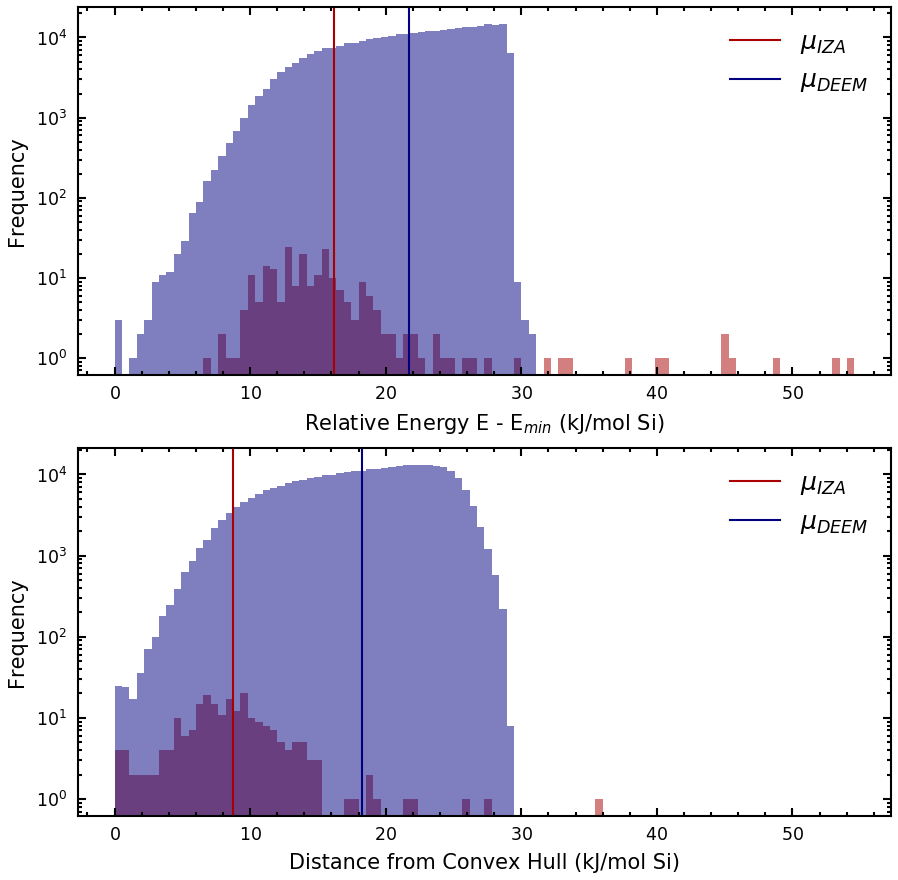

In [60]:
fig = plt.figure(figsize=(7.0, 7.0))
axs_energy = fig.add_subplot(2, 1, 1)
axs_hull = fig.add_subplot(2, 1, 2, sharex=axs_energy)

energy_histogram_parameters = dict(
    #range=(np.amin(energies), np.amax(energies)), 
    range=(0.0, np.amax(energies)-np.amin(energies)), 
    density=False, bins=100, log=True, alpha=0.5
)

hull_histogram_parameters = dict(
    #range=(np.amin(de), np.amax(de)),
    range=(0.0, np.amax(energies)-np.amin(energies)), 
    density=False, bins=100, log=True, alpha=0.5
)

# Histogram of GULP energies
axs_energy.hist(energies[0:n_iza]-np.amin(energies), **energy_histogram_parameters, facecolor=color_list[1])
axs_energy.axvline(np.mean(energies[0:n_iza]-np.amin(energies)), color=color_list[1], label=r'$\mu_{IZA}$')

axs_energy.hist(energies[n_iza:]-np.amin(energies), **energy_histogram_parameters, facecolor=color_list[2])
axs_energy.axvline(np.mean(energies[n_iza:]-np.amin(energies)), color=color_list[2], label=r'$\mu_{DEEM}$')

axs_energy.set_ylabel('Frequency')
axs_energy.set_xlabel(r'Relative Energy E - E$_{min}$ (kJ/mol Si)')
axs_energy.ticklabel_format(axis='x', style='plain', scilimits=(0, 0), useMathText=True)

axs_energy.legend(fontsize='large')

# Histogram of (energy) distances from convex hull
axs_hull.hist(de[0:n_iza], **hull_histogram_parameters, facecolor=color_list[1])
axs_hull.axvline(np.mean(de[0:n_iza]), color=color_list[1], label=r'$\mu_{IZA}$')

axs_hull.hist(de[n_iza:], **hull_histogram_parameters, facecolor=color_list[2])
axs_hull.axvline(np.mean(de[n_iza:]), color=color_list[2], label=r'$\mu_{DEEM}$')

axs_hull.set_ylabel('Frequency')
axs_hull.set_xlabel('Distance from Convex Hull (kJ/mol Si)')

axs_hull.legend(fontsize='large')

fig.savefig('../../Results/6.0/energy_hull_histogram_6.0.pdf', bbox_inches='tight')

plt.show()

# Build a chemiscope

In [ ]:
sys.path.append('/home/helfrech/Tools/chemiscope/utils')
from chemiscope_input import write_chemiscope_input

In [ ]:
deem = read('../../Raw_Data/DEEM_330k/XYZ/DEEM_331172.xyz', index=':')
iza = read('../../Raw_Data/GULP/IZA_226/Final_Confs.xyz', index=':')

In [ ]:
# TODO: load the actual saved classes
true_classes_iza = np.array([f'IZA{i}' for i in cantons_iza])
true_classes_deem = np.array(['DEEM']*len(deem))
true_classes = np.concatenate((true_classes_iza, true_classes_deem))

predicted_classes_iza = \
    np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/pcovr_structure_cantons.dat', dtype=int)
predicted_classes_deem = \
    np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/pcovr_structure_cantons.dat', dtype=int)

predicted_classes = np.concatenate((predicted_classes_iza, predicted_classes_deem))
predicted_classes = np.array([f'IZA{pc}' if pc < 4 else 'DEEM' for pc in predicted_classes])

In [ ]:
Si_fraction_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/ChemComp_F.txt', usecols=1)
Si_fraction_deem = np.ones(len(deem)) / 3
Si_fraction = np.concatenate((Si_fraction_iza, Si_fraction_deem))
Si_fraction = np.delete(Si_fraction, iza_delete)

In [ ]:
frames = deepcopy(deem)
for frame in frames:
    for i in ('Energy_unit', 'spacegroup', 'Energy', 'unit_cell'):
        frame.info.pop(i)
        
# Subselect DEEM 330k frames lowest in energy relative to the hull
n_select = 5000 # Won't actually be this many DEEM structures, but close
idxs_select = np.argsort(de)
idxs_select = idxs_select[0:n_select]
idxs_select = idxs_select[idxs_select >= len(iza)] - len(iza)
idxs_select.sort()
frames = [frames[i] for i in idxs_select]
idxs_select = np.union1d(np.arange(0, len(iza)), idxs_select + len(iza))

# Subselect DEEM 330k frames
# idxs_select = gch_vertices.copy()
# idxs_select = idxs_select[idxs_select >= len(iza)] - len(iza)
# n_random = 10000
# idxs_random = np.arange(0, len(frames))
# idxs_random = np.setdiff1d(idxs_random, idxs_select)
# np.random.shuffle(idxs_random)
# idxs_select = np.concatenate((idxs_select, idxs_random[0:n_random]))
# idxs_select.sort()
# frames = [frames[i] for i in idxs_select]  
# idxs_select = np.concatenate((np.arange(0, len(iza)), idxs_select + len(iza)))
        
frames = iza + frames

extra = dict(projection=dict(target='structure', values=T[idxs_select, 0:2]),
             energies=dict(target='structure', values=energies[idxs_select]),
             volumes=dict(target='structure', values=volumes[idxs_select]),
             vertex=dict(target='structure', values=vertices[idxs_select]),
             true_class=dict(target='structure', values=true_classes[idxs_select]),
             predicted_class=dict(target='structure', values=predicted_classes[idxs_select]),
             hull_distance=dict(target='structure', values=d[idxs_select]),
             hull_distance_energy=dict(target='structure', values=de[idxs_select]),
             Si_fraction=dict(target='structure', values=Si_fraction[idxs_select]))

In [ ]:
write_chemiscope_input(f'{gch_dir}/svm-kpcovr-gch_chemiscope_test.json.gz', 
                       frames, 
                       extra=extra, 
                       meta=dict(name='SVM-KPCovR-GCH'), 
                       cutoff=None)

# Plot the "chemiscope"

In [ ]:
with gzip.GzipFile(f'{gch_dir}/svm-kpcovr-gch_chemiscope_test.json.gz', 'r') as f:
    data = json.load(f)

In [ ]:
T1 = np.array(data['properties']['projection[1]']['values'])
T2 = np.array(data['properties']['projection[2]']['values'])
E = np.array(data['properties']['Energy_per_Si']['values'])
hull_distance = np.array(data['properties']['hull_distance']['values'])
hull_distance_energy = np.array(data['properties']['hull_distance_energy']['values'])
true_class = np.array(data['properties']['true_class']['values'])
predicted_class = np.array(data['properties']['predicted_class']['values'])

In [ ]:
symbols = []
for t in true_class:
    if t == 'DEEM':
        symbols.append('circle')
    elif t == 'IZA1':
        symbols.append('square')
    elif t == 'IZA2':
        symbols.append('diamond')
    elif t == 'IZA3':
        symbols.append('cross')

In [ ]:
classes = sorted(list(set(true_class)))

In [ ]:
fig = go.Figure()

for t, s in zip(classes, ('circle', 'square', 'diamond', 'cross')):
    X = T1[true_class == t]
    Y = T2[true_class == t]
    Z = E[true_class == t]
    HDE = hull_distance_energy[true_class == t]
    fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='markers',
                               marker=dict(color=HDE,
                                           coloraxis='coloraxis',
                                           line_width=1,
                                           size=3,
                                           symbol=s),
                              name=t))

fig.update_layout(template='plotly_white',
                  scene=dict(xaxis_title='T<sub>1</sub>',
                             yaxis_title='T<sub>2</sub>',
                             zaxis_title='Energy per Si<br>(kJ/mol Si)'),
                  legend=dict(x=0.0, y=1.0,
                              xanchor='left', yanchor='top',
                              itemsizing='constant'),
                  coloraxis=dict(colorscale='Plasma',
                                 colorbar=dict(title='Hull Distance<br>(kJ/mol)')),
                  autosize=False,
                  width=600, height=600)

fig.show()
#fig.write_image('../../Results/6.0/SVM-KPCovR-GCH.png')